In [1]:
import os
import sys

sys.path.append("..")

from lightgbm import LGBMRanker
from sklearn.utils import check_random_state
from xai_ranking.benchmarks import (
    human_in_the_loop_experiment,
    human_in_the_loop_batch_experiment,
    hierarchical_ranking_explanation,
    hierarchical_ranking_batch_explanation,
    lime_experiment,
    lime_batch_experiment,
    shap_experiment,
    shap_batch_experiment,
    sharp_experiment,
    sharp_batch_experiment,
    # participation_experiment,
)
from xai_ranking.preprocessing import (
    preprocess_atp_data,
    preprocess_csrank_data,
    preprocess_higher_education_data,
    preprocess_movers_data,
)
from xai_ranking.datasets import (
    fetch_atp_data,
    fetch_csrank_data,
    fetch_higher_education_data,
    fetch_movers_data,
)
from xai_ranking.scorers import (
    atp_score,
    csrank_score,
    higher_education_score,
)
from xai_ranking.metrics import compute_all_stability, compute_all_agreement, compute_all_sensitivity, compute_all_fidelity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlresearch.utils import check_random_states, set_matplotlib_style
from sharp.utils import scores_to_ordering

RNG_SEED = 42

In [2]:
# Set up ranker for the moving company dataset:
X, ranks, score = preprocess_movers_data(fetch_movers_data(test=False))
qids_train = X.index.value_counts().to_numpy()

model = LGBMRanker(
    objective="lambdarank", label_gain=list(range(max(ranks) + 1)), verbose=-1
)
model.fit(
    X=X,
    y=ranks,
    group=qids_train,
)

LGBMRanker(label_gain=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
           objective='lambdarank', verbose=-1)

In [3]:
datasets = [
    {
        "name": "ATP",
        "data": preprocess_atp_data(fetch_atp_data()),
        "scorer": atp_score,
    },
    {
        "name": "CSRank",
        "data": preprocess_csrank_data(fetch_csrank_data()),
        "scorer": csrank_score,
    },
    {
        "name": "Higher Education",
        "data": preprocess_higher_education_data(
            fetch_higher_education_data(year=2020)
        ),
        "scorer": higher_education_score,
    },
    {
        "name": "Moving Company",
        "data": preprocess_movers_data(fetch_movers_data(test=True)),
        "scorer": model.predict,
    },
]
xai_methods = [
    {
        "iterations": 1,
        "name": "LIME",
        "experiment": lime_experiment,
        "kwargs": {"mode": "regression"}  # classification, regression
    },
    {
        "iterations": 10,
        "name": "BATCH_LIME",
        "experiment": lime_batch_experiment,
        "kwargs": {"mode": "regression"}  # classification, regression
    },
    {
        "iterations": 1,
        "name": "SHAP",
        "experiment": shap_experiment,
        "kwargs": {}
    },
    {
        "iterations": 10,
        "name": "BATCH_SHAP",
        "experiment": shap_batch_experiment,
        "kwargs": {}
    },
    {
        "iterations": 1,
        "name": "ShaRP",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            # "sample_size": 150,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": True
        }
    },
    {
        "iterations": 10,
        "name": "BATCH_ShaRP",
        "experiment": sharp_batch_experiment,
        "kwargs": {
            "verbose": True,
            # "sample_size": 150,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": True
        }
    },
    {
        "iterations": 1,
        "name": "HRE",
        "experiment": hierarchical_ranking_explanation,
        "kwargs": {
            "model_type": "OLS",  # DT, LR, OLS, PLS
            "s": 5
        }
    },
    {
        "iterations": 10,
        "name": "BATCH_HRE",
        "experiment": hierarchical_ranking_batch_explanation,
        "kwargs": {
            "model_type": "OLS",  # DT, LR, OLS, PLS
            "s": 5
        }
    },
    {
        "iterations": 1,
        "name": "HIL",
        "experiment": human_in_the_loop_experiment,
        "kwargs": {"upper_bound": 1, "lower_bound": None}
    },
    {
        "iterations": 10,
        "name": "BATCH_HIL",
        "experiment": human_in_the_loop_batch_experiment,
        "kwargs": {"upper_bound": 1, "lower_bound": None}
    },
    # {"iterations": 1, "name": "Participation", "experiment": participation_experiment},
]

total_states = sum(map(lambda x: x["iterations"], xai_methods)) * len(datasets)
random_states = (x for x in check_random_states(RNG_SEED, total_states))

In [ ]:
results = {}
for dataset in datasets:
    results[dataset["name"]] = {}
    for xai_method in xai_methods:
        results[dataset["name"]][xai_method["name"]] = []

        experiment_func = xai_method["experiment"]
        score_func = dataset["scorer"]

        X, ranks, scores = dataset["data"]

        for iteration_idx in range(xai_method["iterations"]):
            random_state = next(random_states)
            if "done" in dataset and dataset["done"]:
                continue

            kwargs = {} if "kwargs" not in xai_method else xai_method["kwargs"]
            if dataset["name"] == "Moving Company" and xai_method["name"].endswith("ShaRP"):
                kwargs["sample_size"] = 150

            contributions = experiment_func(X, score_func, random_state=random_state, **kwargs)

            results[dataset["name"]][xai_method["name"]].append(contributions)
            result_df = pd.DataFrame(contributions, columns=X.columns, index=X.index)
            result_df.to_csv(
                f"results/_contributions_{dataset['name']}_{xai_method['name']}_{iteration_idx}.csv"
            )
        # with open(f"_contributions_{dataset['name']}_{xai_method['name']}.npy", "wb") as f:
        #     np.save(f, contributions)

In [4]:
def read_results_from_files():
    return_dict = {}
    for cur_dataset in datasets:
        return_dict[cur_dataset["name"]] = {}
        for cur_xai_method in xai_methods:
            return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
            for iteration in range(cur_xai_method["iterations"]):
                fname = (
                    f"results/_contributions_"
                    f"{cur_dataset['name']}_{cur_xai_method['name']}_"
                    f"{iteration}.csv"
                )
                if os.path.isfile(fname):
                    (
                        return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
                            pd.read_csv(fname, index_col=0)
                        )
                    )
    return return_dict

In [5]:
results = read_results_from_files()

In [6]:
results

{'ATP': {'LIME': [                         serve__pct_1st_serve  \
   player_name                                     
   John Isner                           5.550138   
   Nick Kyrgios                         5.881460   
   Reilly Opelka                        1.566776   
   Hubert Hurkacz                      -1.140986   
   Matteo Berrettini                    1.415160   
   ...                                       ...   
   Diego Schwartzman                    5.839756   
   Fabio Fognini                       -5.856378   
   Cristian Garin                      -1.414316   
   Bernabe Zapata Miralles              1.522356   
   Nikoloz Basilashvili                -6.314378   
   
                            serve__pct_1st_serve_points_won  \
   player_name                                                
   John Isner                                      8.206873   
   Nick Kyrgios                                    8.187097   
   Reilly Opelka                                   8.

# Stability

In [7]:
aggregated_summary, aggregated_error = compute_all_stability(results, axis=None)
pd.DataFrame(aggregated_summary)

Error in dataset: Moving Company, with method: ShaRP


,ATP,CSRank,Higher Education,Moving Company
HIL,0.048261,0.378191,1.519957e+00,NaN
HRE,22.401588,219.469184,3.669743e-12,NaN
LIME,24.390732,3.875318,9.151029e+01,2.753672
SHAP,7.237256,3.615071,3.239761e+01,4.602695
ShaRP,50.512616,153.607195,3.565079e+03,NaN


In [8]:
def plot_dataset_aggregated_summary(agg_mean, agg_sem, gap=0.3):
    n_cols = len(agg_mean.columns)
    x = np.arange(n_cols).astype(np.float64)

    methods = agg_mean.index.unique()
    bars = len(methods)
    bar_width = (1 - gap) / bars
    x -= (bars - 1) * bar_width / 2

    for method in methods:
        plt.errorbar(
            x,
            agg_mean.loc[method],
            yerr=agg_sem.loc[method],
            marker="o",
            label=method,
            linestyle="None",
        )
        x += bar_width
    plt.legend()
    plt.xticks(np.arange(n_cols), agg_mean.columns, rotation=45)

Could not find a LaTeX installation. ``text.usetex`` will be set to False.


Error in dataset: Moving Company, with method: ShaRP


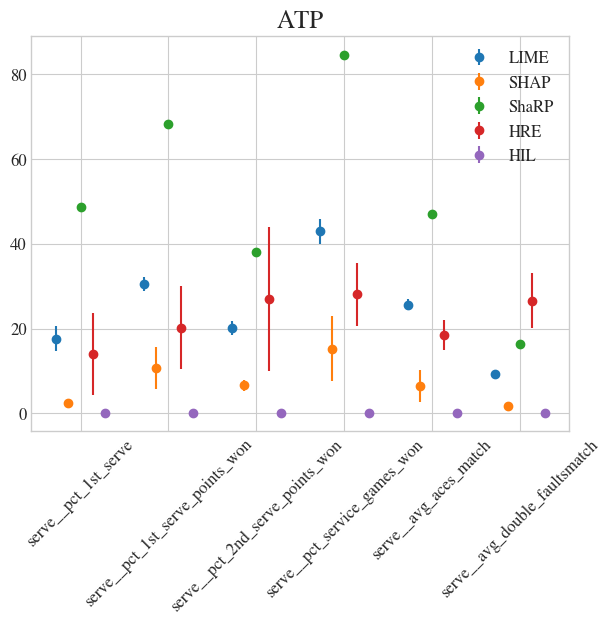

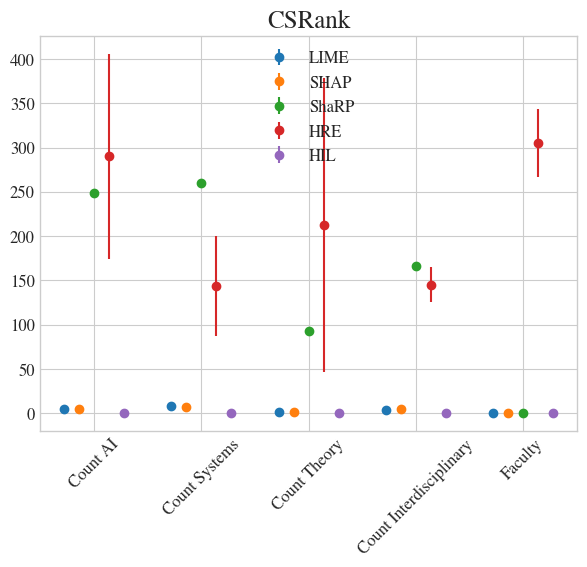

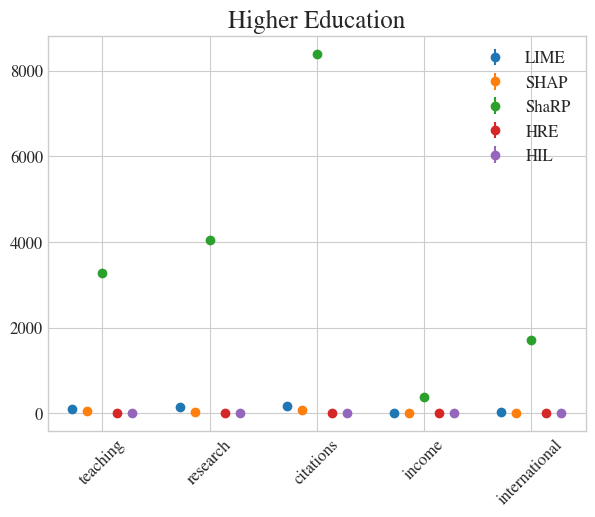

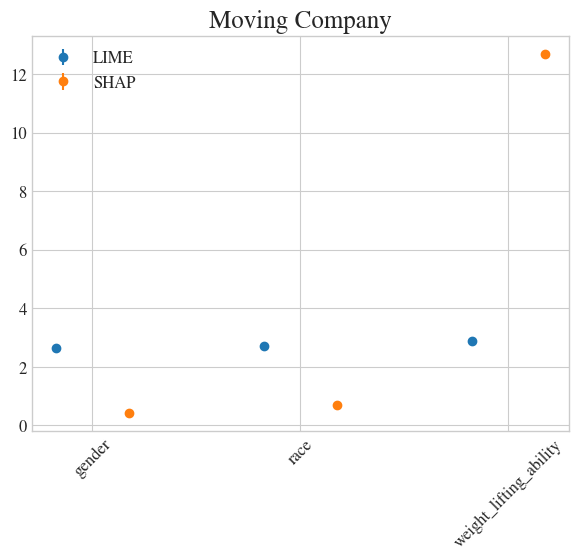

In [9]:
set_matplotlib_style(font_size=12, **{"font.family": ["Nimbus Roman"]})
aggregated_summary, aggregated_error = compute_all_stability(results, axis=0)
for dataset in aggregated_summary:
    plot_dataset_aggregated_summary(
        aggregated_summary[dataset], aggregated_error[dataset]
    )
    plt.title(dataset)
    plt.show()

# Agreement

In [10]:
agreement_results = compute_all_agreement(results, n_features=3)
agreement_results["ATP"]["kendall"]

Error in dataset: Moving Company, with methods: LIME, ShaRP
Error in dataset: Moving Company, with methods: LIME, HRE
Error in dataset: Moving Company, with methods: LIME, HIL
Error in dataset: Moving Company, with methods: SHAP, ShaRP
Error in dataset: Moving Company, with methods: SHAP, HRE
Error in dataset: Moving Company, with methods: SHAP, HIL
Error in dataset: Moving Company, with methods: ShaRP, LIME
Error in dataset: Moving Company, with methods: ShaRP, SHAP
Error in dataset: Moving Company, with methods: ShaRP, ShaRP
Error in dataset: Moving Company, with methods: ShaRP, HRE
Error in dataset: Moving Company, with methods: ShaRP, HIL
Error in dataset: Moving Company, with methods: HRE, LIME
Error in dataset: Moving Company, with methods: HRE, SHAP
Error in dataset: Moving Company, with methods: HRE, ShaRP
Error in dataset: Moving Company, with methods: HRE, HRE
Error in dataset: Moving Company, with methods: HRE, HIL
Error in dataset: Moving Company, with methods: HIL, LIME
Er

,LIME,SHAP,ShaRP,HRE,HIL
LIME,1.0,0.804651,0.790698,0.0,-0.062016
SHAP,0.804651,1.0,0.933333,0.003101,-0.071318
ShaRP,0.790698,0.933333,1.0,0.020155,-0.07907
HRE,0.0,0.003101,0.020155,1.0,0.156589
HIL,-0.062016,-0.071318,-0.07907,0.156589,1.0


In [11]:
agreement_results["ATP"]["jaccard"]

,LIME,SHAP,ShaRP,HRE,HIL
LIME,1.0,0.886047,0.868605,0.359302,0.39186
SHAP,0.886047,1.0,0.947674,0.35814,0.402326
ShaRP,0.868605,0.947674,1.0,0.355814,0.398837
HRE,0.359302,0.35814,0.355814,1.0,0.390698
HIL,0.39186,0.402326,0.398837,0.390698,1.0


In [12]:
agreement_results["CSRank"]["kendall"]

,LIME,SHAP,ShaRP,HRE,HIL
LIME,1.0,0.78836,0.685714,-0.065608,0.008466
SHAP,0.78836,1.0,0.649735,-0.154497,0.025397
ShaRP,0.685714,0.649735,1.0,0.128042,-0.085714
HRE,-0.065608,-0.154497,0.128042,1.0,-0.144974
HIL,0.008466,0.025397,-0.085714,-0.144974,1.0


In [13]:
agreement_results["CSRank"]["jaccard"]

,LIME,SHAP,ShaRP,HRE,HIL
LIME,1.0,0.841799,0.806878,0.455026,0.426455
SHAP,0.841799,1.0,0.788889,0.436508,0.439153
ShaRP,0.806878,0.788889,1.0,0.569841,0.414286
HRE,0.455026,0.436508,0.569841,1.0,0.39418
HIL,0.426455,0.439153,0.414286,0.39418,1.0


In [14]:
agreement_results["Higher Education"]["kendall"]

,LIME,SHAP,ShaRP,HRE,HIL
LIME,1.0,0.81446,0.797423,-0.147459,-0.044381
SHAP,0.81446,1.0,0.825483,-0.187545,0.012598
ShaRP,0.797423,0.825483,1.0,-0.04796,-0.114102
HRE,-0.147459,-0.187545,-0.04796,1.0,0.041947
HIL,-0.044381,0.012598,-0.114102,0.041947,1.0


# Sensitivity

In [15]:
sensitivity_results = compute_all_sensitivity(
    original_data=datasets, 
    results=results, 
    n_neighbors=10
)

Error in dataset: Moving Company, with method: ShaRP
Error in dataset: Moving Company, with method: HRE
Error in dataset: Moving Company, with method: HIL


In [16]:
pd.DataFrame(sensitivity_results[0])

,ATP,CSRank,Higher Education,Moving Company
HIL,0.260000,-0.040529,0.146127,NaN
HRE,0.353798,0.767937,0.712770,NaN
LIME,0.169767,0.536614,0.377409,0.556167
SHAP,0.130543,0.603280,0.358969,0.805500
ShaRP,0.167597,0.446984,0.326142,NaN


# Fidelity

In [17]:
fidelity_results = compute_all_fidelity(
    original_data=datasets, 
    results=results, 
    random_state=RNG_SEED
)
pd.DataFrame(fidelity_results[0])

Error in dataset: Moving Company, with method: ShaRP
Error in dataset: Moving Company, with method: HRE
Error in dataset: Moving Company, with method: HIL


,ATP,CSRank,Higher Education,Moving Company
LIME,1.660202,5.802080,17.611022,73.761219
SHAP,1.724879,4.185789,18.012614,277.032029
ShaRP,1.768822,6.423129,20.269573,NaN
HRE,1.567466,6.539259,10.781634,NaN
HIL,1.724879,9.066170,24.860514,NaN


In [20]:
pd.DataFrame(fidelity_results[0]).mean(1)# .drop(columns="Moving Company").mean(1)

LIME     24.708631
SHAP     75.238828
ShaRP     9.487175
HRE       6.296120
HIL      11.883854
dtype: float64